# 주식 예측 모델

이번 프로젝트에서는 ARIMA모델을 이용하여 시계열데이터의 하나인 주식데이터에 대한 예측을 해보겠다. 

![d](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp11/data/11.png?raw=true)

---

### 데이터 수집: Yahoo Finance 데이터 불러오기

관련데이터는 Yahoo Finance 사이트에서 다운받았다. 아래 종목에 대한 2020년 5월 18일부터 2021년 5월 18일까지 1년동안의 주식데이터이다.

- [Samsung Electronics Co., Ltd. (005930.KS)](https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS)
- [NAVER Corporation (035420.KS)](https://finance.yahoo.com/quote/035420.KS/history?p=035420.KS)
- [Hyundai Motor Company (005380.KS)](https://finance.yahoo.com/quote/005380.KS/history?p=005380.KS)

---
## 1. 주식 예측 - 삼성

### 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 데이터 로드


### load_data 함수 정의
1. csv 파일 읽기
 - index_col='Date' : 시계열 데이터의 시간에 해당하는 독립변수로 날짜를 설정
2. 종가 데이터(Close컬럼)만 시계열 데이터로 설정
3. 시계열 데이터의 결측치 처리
 - 시계열(Time Series) 데이터나 연속된 수치를 가지는 데이터의 경우 연속성있는 패턴이 있는 데이터이므로 보간(Interpolation)을 통해 앞,뒤 값을 통하여 유추하여 결측치를 채운다.
 - Pandas의 Interpolation 함수 사용
  - method=time : 주어진 간격의 길이를 보간하기 위해 시간에 따라 비례하는 데이터를 대입
 ![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F27380C3F584C23A617)
 
4. 시계열 데이터를 반환한다.




In [2]:
# Time Series 생성
def load_data(file_name):
    dataset_filepath = os.getenv('HOME') + file_name
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

    #종가 데이터만 시계열 데이터로 설정
    ts = df['Close']
    
    #결측치 처리
    nullcount = len(ts[ts.isna()])
    if nullcount > 0 :
        # 보간에 의한 결측치 대입 - Interpolation 함수
        ts = ts.interpolate(method='time')
    
    return ts  

ts_ss = load_data('/aiffel/project/exp11_StockPrediction/data/005930.KS.csv' )

In [3]:
ts_ss.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 시계열 데이터 안정성 확인

Augmented Dickey-Fuller Test로 시계열 데이터의 안정성을 정량적으로 평가해보자.

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_ss)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


삼성 주식 데이터에 대한 p-value(시계열이 안정적이지 않다는 귀무가설)가 0.66으로 나타났다. p-value 값이 0.05 미만으로 낮게 나와야 귀무가설을 기각하고 대립가설을 채택할수 있으므로 귀무가설이 유지된다. 따라서 이경우는 귀무가설에따라 주어진 시계열데이터가 안정적이지 않다고 볼수 있다.

이제 안정적이지 않은 시계열 데이터에 대한 처리를 해주겠다.

### 시계열 분해(Time Series Decomposing)를 통한 시계열 데이터 가공

시계열 데이터를 Stationary하게 만드는 방법
1. 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도
2. 시계열 분해(Time series decomposition) 기법을 적용

본프로젝트에서는 두방법중 시계열 분해 방법을 적용하도록 하겠다. 
데이터 가공에 앞서 시계열의 데이터의 분산 변화를 일정하게 하기위해 로그변환을 한다.


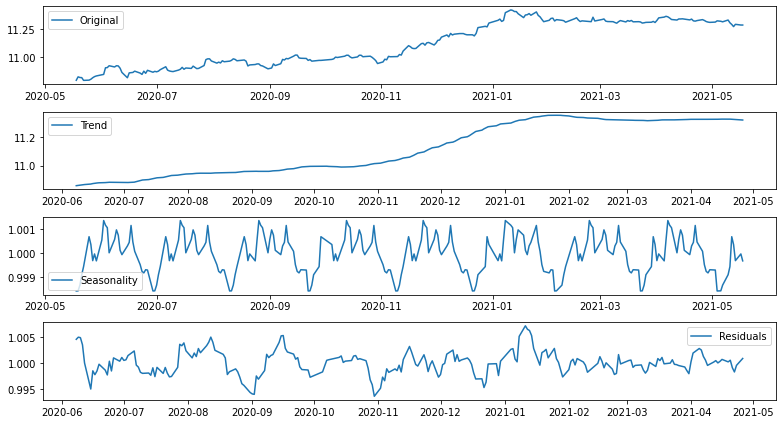

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

def apply_decomposition(ts):
    #로그변환 
    ts_log = np.log(ts)
    
    #시계열 데이터 안정적으로 변환
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    
    return ts_log, decomposition

def show_ts_data(ts_log, decomposition):
    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

#시계열 데이터 안정적으로 변환
ts_log_ss,decomposition_ss = apply_decomposition(ts_ss)
#변환된 시계열 데이터 시각화
show_ts_data(ts_log_ss, decomposition_ss)

변환된 데이터로 다시 안정성을 확인해보자.

In [14]:
# Residual 안정성 확인
residual_ss = decomposition_ss.resid

residual_ss.dropna(inplace=True)
augmented_dickey_fuller_test(residual_ss)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


아주작은 p-vlaue가 확인되었다. 이제 학습, 테스트 데이터셋을 구성하여 학습을 진행해보겠다.
```
p-value                        6.234854e-08
```


### 적정 ARIMA 모수 찾기
주식예측을 위해 ARIMA 모델을 사용할것인데 예측할 시계열데이터에 맞는 모수(p,d,q)를 적절히 설정해주어야한다.

- ARIMA 분석의 파라미터
ARIMA 모델의 order 파라미터 p, d, q는 일반적인 가이드라인이 존재한다. 보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다. 아래표의 요약을 보면 ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있다. d파라미터의 경우 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 한다.

p와 q파라미터중 하나의 모수는 보통 0이 되는데, 실제로 대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에, 이렇게 사용하는 경우가 많다고 한다.

 - ACF, PACF 그려보기 -> p,q 구하기
 - 차분 안정성 확인 -> d 구하기

![d](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp11/data/03.png?raw=true)



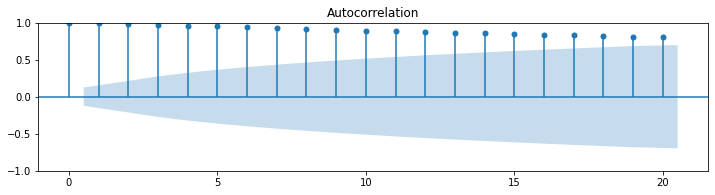

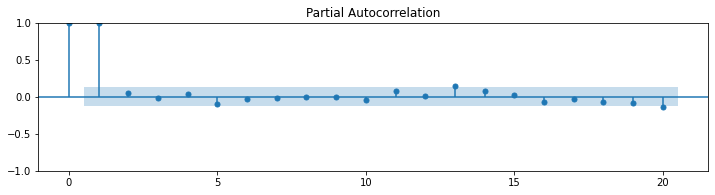

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    # ACF : Autocorrelation 그래프 그리기
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=20, ax=ax1) 

    # PACF : Partial Autocorrelation 그래프 그리기  
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=20, ax=ax1)

plot_acf_pacf(ts_log_ss)
  

ACF 그래프의 경우 점차 감소하는 모습을 보이고 있고 PACF 그래프의 경우 1의 Time lag에서 1값을 보이고 2이후로 값이 0이 되고있으므로 AR(1)인 모델에 가깝다고 할수있겠다. 따라서 p=1, q=0 으로 설정하면되겠다.

현재 시계열이 안정된 상태상태이므로 적절한 차분 차수(d)는 0으로 둘수 있겠다.

Results of Dickey-Fuller Test:
Test Statistic                -7.086435e+00
p-value                        4.525802e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.040000e+02
Critical Value (1%)           -3.462818e+00
Critical Value (5%)           -2.875815e+00
Critical Value (10%)          -2.574379e+00
dtype: float64


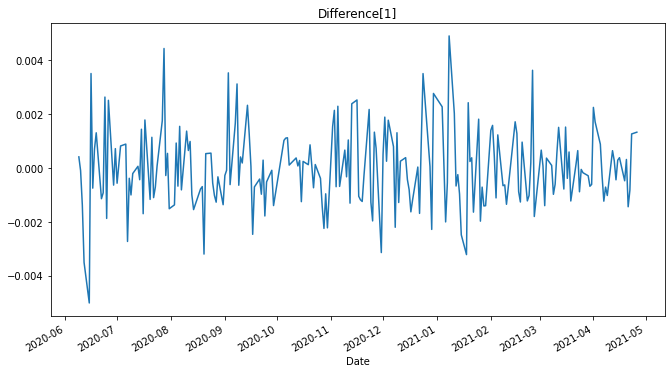

In [8]:
# 1차 차분 구하기
def plot_defference(data, no):
    diff = data.diff(periods=1).iloc[1:]
    title = 'Difference['+str(no)+']'
    diff.plot(title=title)    

    augmented_dickey_fuller_test(diff)
    return diff
    
    
diff_1 = plot_defference(residual_ss, 1)

#2차 차분 구하기
#diff_2 = plot_defference(diff_1, 2)

차분이후 p-value가 2.183738e-28 아주 작은값이 되었다. 이미 차분전에도 시계열데이터가 안정화된 상태이으므로 차분없이 p=1, d=0, q=0으로 설정하여 ARIMA모델에 적용해보겠다.

### 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋비율을 9:1로 정하고 10%에 대한 주식 예측을 진행해보겠다.

In [16]:
#학습, 테스트 데이터셋 설정
def splite_train_test(data):    
    train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]
    return train_data, test_data

train_data_ss, test_data_ss = splite_train_test(ts_log_ss)

### ARIMA 모델 훈련



In [17]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model

model = ARIMA(train_data_ss, order=(4, 0, 0)) 
fitted_data_ss = model.fit() 

print(fitted_data_ss.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 583.454
Date:                Thu, 17 Feb 2022   AIC                          -1154.908
Time:                        12:29:30   BIC                          -1134.411
Sample:                             0   HQIC                         -1146.635
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.128     86.517      0.000      10.838      11.341
ar.L1          1.0329      0.062     16.556      0.000       0.911       1.155
ar.L2         -0.0457      0.107     -0.427      0.6

ARIMA 모델이 훈련 결과를 시각적으로 확인해보자.

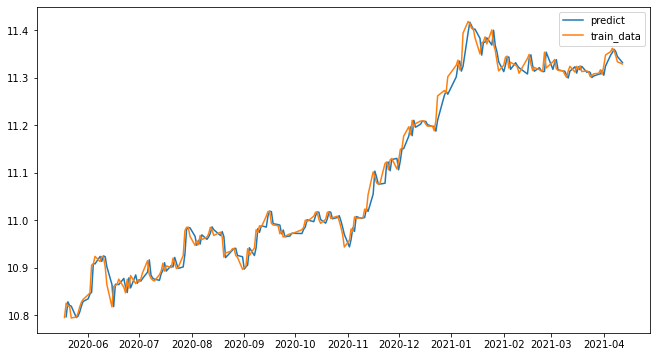

In [46]:
def plot_fitted_data(train_data, fitted_m):
    fitted_m = fitted_m.predict()
    fitted_m = fitted_m.drop(fitted_m.index[0])
    plt.plot(fitted_m, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()
    
    return fitted_m

fitted_data_ss = plot_fitted_data(train_data_ss, fitted_data_ss)

### 주식 시세 예측

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해 봅니다.

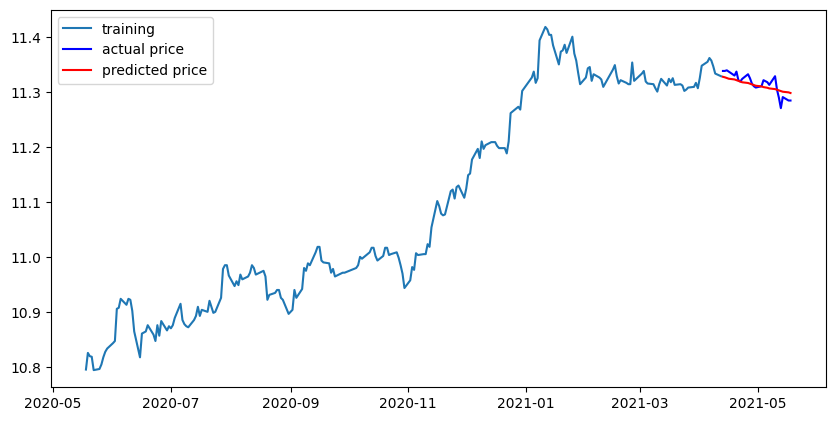

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
def forcast(fitted_data, train_data, test_data):
    fc = fitted_data.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

model = ARIMA(train_data_ss, order=(4, 0, 0)) 
fitted_data_ss = model.fit() 
fc_data_ss = forcast(fitted_data_ss, train_data_ss, test_data_ss)

실제 주식가와 비슷한 예측을 해낸것을 확인할 수 있다.

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산해보자.
- np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
- 본프로젝트에서는 최종적으로 예측 정확도를 확인하는 지표로 MAPE를 사용했다.
 - MAPE(Mean absolute percentage error) : 평균 절대 백분율 오차


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def check_error(test_data, fc_data):    
    mse = mean_squared_error(np.exp(test_data), np.exp(fc_data))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc_data))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_data)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc_data) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

check_error(test_data_ss, fc_data_ss)

MSE:  1016402.2063743202
MAE:  813.4029744335729
RMSE:  1008.1677471404846
MAPE: 0.99%


MAPE 기준 예측오차가 1%남짓으로 ARIMA(1, 0, 0) 모델의 예측성능이 좋은것을 확인하였다.

---
## 2. 주식 예측 - Naver


In [20]:
ts_naver = load_data('/aiffel/project/exp11_StockPrediction/data/035420.KS.csv' )

#데이터 안정성확인
augmented_dickey_fuller_test(ts_naver)

Results of Dickey-Fuller Test:
Test Statistic                  -1.999072
p-value                          0.286980
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 0.286980으로 안정성을 위한 기준인 0.05 보다 크므로 데이터 가공을 통해 안정화를 시키겠다.

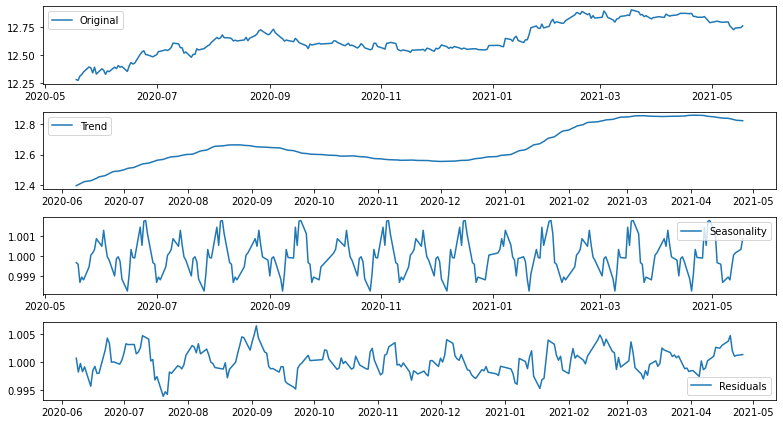

In [21]:
#시계열 데이터 안정적으로 변환
ts_log_naver,decomposition_naver = apply_decomposition(ts_naver)
#변환된 시계열 데이터 시각화
show_ts_data(ts_log_naver, decomposition_naver)

In [22]:
# Residual 안정성 확인
residual_naver = decomposition_naver.resid

residual_naver.dropna(inplace=True)
augmented_dickey_fuller_test(residual_naver)

Results of Dickey-Fuller Test:
Test Statistic                -5.935052e+00
p-value                        2.331583e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


안정성이 확인되었다. 이제 적절한 ARIMA 모수를 찾아보자.

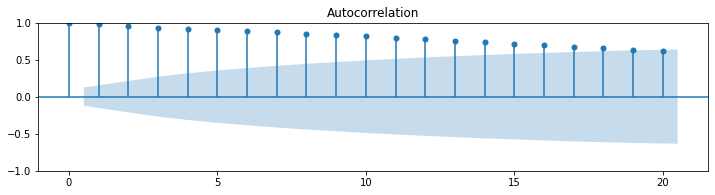

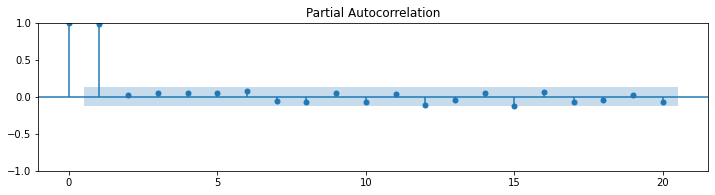

In [23]:
plot_acf_pacf(ts_log_naver)

같은 기간의 삼성주식과 비슷한 형태의 그래프가 확인된다. 모수를 삼성주식예측과  같은 p=1, d=0, q=0으로 설정하여 ARIMA모델에 적용해보겠다.

In [24]:
#학습, 테스트 데이터셋 설정
train_data_naver, test_data_naver = splite_train_test(ts_log_naver)

# Build Model
model_naver = ARIMA(train_data_naver, order=(1, 0, 0)) 
fitted_data_naver = model_naver.fit() 



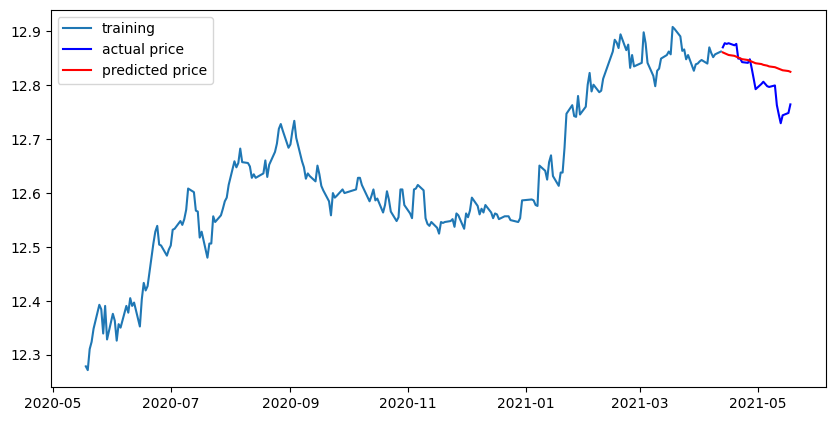

MSE:  264424877.90806141
MAE:  12767.476127304068
RMSE:  16261.146266732288
MAPE: 3.59%


In [25]:
fc_data_naver = forcast(fitted_data_naver, train_data_naver, test_data_naver)
check_error(test_data_naver, fc_data_naver)

MAPE 오차가 3.59%으로 삼성주식 예측시보다 약간 높게 나와 ACF, PACF 그래프를 보고  모수를 다시 설정해보겠다. 

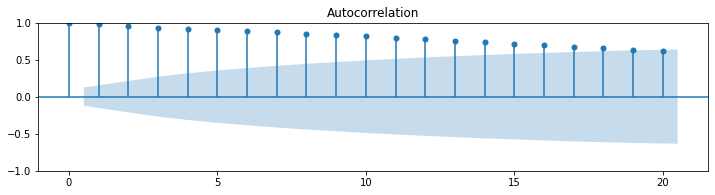

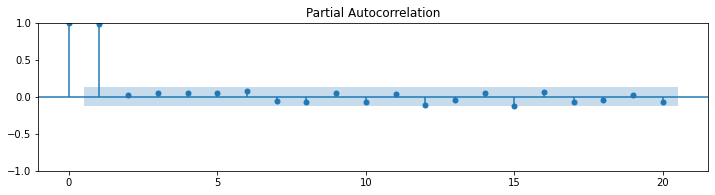

In [26]:
plot_acf_pacf(ts_log_naver)

ACF의 음영부분은 컨피던스레벨로 95프로의 확률로 해당영역에 래깅된 차수에 대해 연관이 있다고 보는 경계선을 나타낸다고 한다. 즉 음영역역에 들어온 19를 p값으로 설정하야 다시 모델을 돌려보겠다.

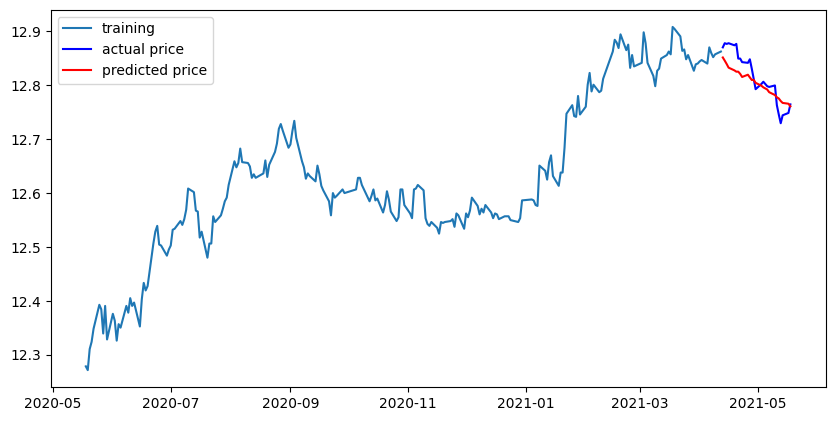

MSE:  101117588.58032702
MAE:  8567.541246664568
RMSE:  10055.724169861016
MAPE: 2.30%


In [32]:
model_naver = ARIMA(train_data_naver, order=(19, 0, 0)) 
fitted_data_naver = model_naver.fit() 
fc_data_naver = forcast(fitted_data_naver, train_data_naver, test_data_naver)
check_error(test_data_naver, fc_data_naver)

p=19을 줄 경우 MAPE가 2% 정도로 내려가 예측이 더 잘되는 것을 확인할수 있다.

---
## 3. 주식 예측 - 현대자동차


In [61]:
ts_hm = load_data('/aiffel/project/exp11_StockPrediction/data/005380.KS.csv' )

#데이터 안정성확인
augmented_dickey_fuller_test(ts_hm)

Results of Dickey-Fuller Test:
Test Statistic                  -1.431100
p-value                          0.567279
#Lags Used                       1.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


p-value가 0.567279으로 안정성을 위한 기준인 0.05 보다 크므로 데이터 가공을 통해 안정화를 시키겠다.

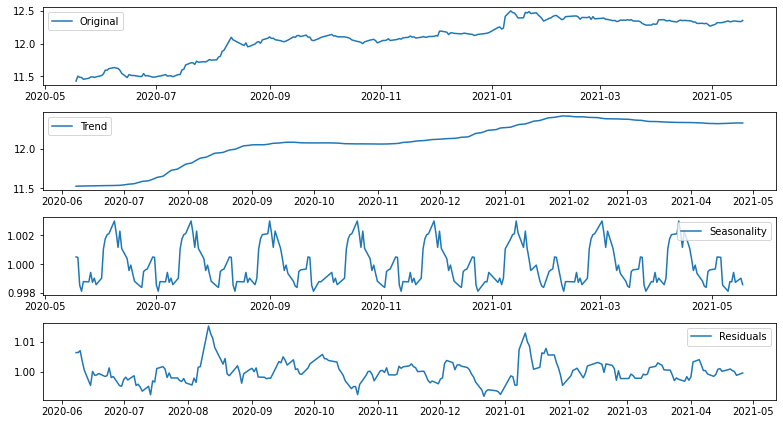

In [62]:
#시계열 데이터 안정적으로 변환
ts_log_hm,decomposition_hm = apply_decomposition(ts_hm)
#변환된 시계열 데이터 시각화
show_ts_data(ts_log_hm, decomposition_hm)

In [66]:
# Residual 안정성 확인
residual_hm = decomposition_dh.resid

residual_hm.dropna(inplace=True)
augmented_dickey_fuller_test(residual_hm)

Results of Dickey-Fuller Test:
Test Statistic                -5.923296e+00
p-value                        2.477210e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


안정성이 확인되었다. 적절한 ARIMA 모수를 찾아보겠다.

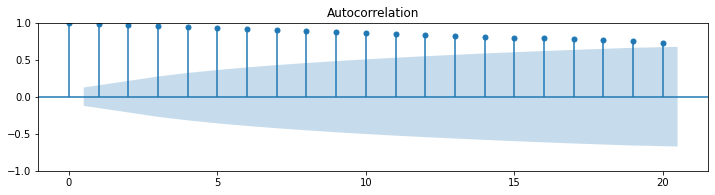

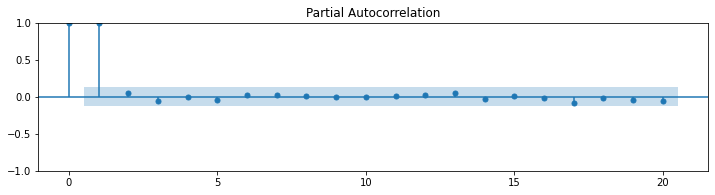

In [67]:
plot_acf_pacf(ts_log_hm)

In [70]:
#학습, 테스트 데이터셋 설정
train_data_hm, test_data_hm = splite_train_test(ts_log_hm)

# Build Model
model = ARIMA(train_data_hm, order=(1, 0, 0)) 
fitted_data_hm = model.fit() 

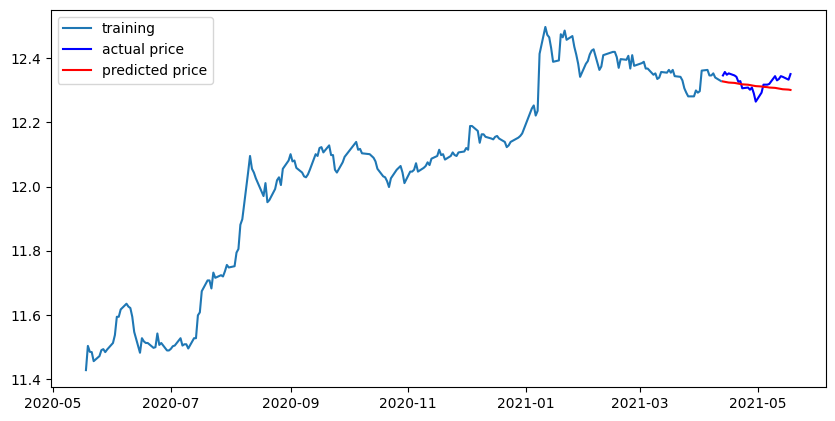

MSE:  34072328.51833727
MAE:  5092.37560963935
RMSE:  5837.150719172606
MAPE: 2.25%


In [71]:
fc_data_hm = forcast(fitted_data_hm, train_data_hm, test_data_hm)
check_error(test_data_hm, fc_data_hm)

---

## 정리

- ARIMA 모델을 이용하여 시계열 데이터에 대한 예측을 진행해보았다. 시계열 데이터는 다른 머신러닝 데이터와 다르게 시간을 독립변수로 사용한다는 특징때문에 시간에 따라 회귀가 되거나 추세가 생기는 부분을 잘 이해할 필요가 있었다. 또한 데이터를 모델에 넣기전에 시간에 따라 안정성(stationarity)을 가지도록 처리해주어야 했는데, 당연히 독립변수의 영향(비안정성)으로 결과가 제대로 나오지 않을 것임을 알게되었다.


- 예측을 진행했던 3종목들이 모두 AR(p)모델의 패턴을 보였는데 같은 기간(2020년5월~2021년 5월)에 대한 데이터였기 때문에 시장상황이 비슷했던점이 영향을 미친것 같다. MAPE오류가 모두 5%미만으로 나오긴했지만 ARIMA 모델에 적용해야하는 모수(p,d,q 파라미터)를 좀더 이해하여 오류값을 더 줄여보고, 다른 패턴의 시계열 데이터에 대해 예측해는 시간을 가진다면 좋겠다.


## Reference

- [데이터 보간방법](https://rfriend.tistory.com/264)
- [ARIMA, Python으로 하는 시계열분석](https://byeongkijeong.github.io/ARIMA-with-Python/)
